# PySpark Online Retail II Dataset Analysis

This notebook demonstrates how to load and analyze the Online Retail II dataset using PySpark in Google Colab.


# 2. Data Understanding

## 1. Install Required Packages

First, install PySpark and related dependencies in Google Colab.


In [1]:
# Install required packages
%pip install pyspark pandas openpyxl


Note: you may need to restart the kernel to use updated packages.


## 2. Import Libraries and Initialize Spark Session


In [2]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, sum as spark_sum, count, when, isnan, isnull, desc, min as spark_min, max as spark_max
from pyspark.sql import functions as F
import pandas as pd
import os

# Set environment variables for Windows
os.environ['PYSPARK_PYTHON'] = 'python'
os.environ['PYSPARK_DRIVER_PYTHON'] = 'python'

# Initialize Spark session with enhanced configuration for Windows
spark = SparkSession.builder \
    .appName("OnlineRetailAnalysis") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.execution.arrow.maxRecordsPerBatch", "10000") \
    .config("spark.driver.memory", "2g") \
    .config("spark.executor.memory", "2g") \
    .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "true") \
    .config("spark.python.worker.timeout", "1200") \
    .config("spark.python.worker.reuse", "false") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.sql.execution.pythonUDF.arrow.enabled", "true") \
    .config("spark.sql.adaptive.skewJoin.enabled", "true") \
    .config("spark.network.timeout", "800s") \
    .config("spark.rpc.askTimeout", "800s") \
    .config("spark.rpc.lookupTimeout", "800s") \
    .config("spark.sql.broadcastTimeout", "800s") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "false") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to reduce output noise
spark.sparkContext.setLogLevel("WARN")

print("Spark session initialized successfully!")
print(f"Spark version: {spark.version}")
print(f"Spark UI: {spark.sparkContext.uiWebUrl}")


Spark session initialized successfully!
Spark version: 4.0.1
Spark UI: http://windows10.microdone.cn:4040


## 3. Load Data from GitHub

Since PySpark cannot directly read Excel files, we use pandas to read from GitHub and then convert to Spark DataFrame.


In [7]:
# Use pandas to read Excel file from GitHub (PySpark doesn't support Excel directly)
import pandas as pd
print("Reading Excel file from GitHub...")

# GitHub repository information
github_user = "Hachi630"
github_repo = "BDAS"
file_path = "online_retail_II.xlsx"

# Construct GitHub raw URL
github_url = f"https://raw.githubusercontent.com/{github_user}/{github_repo}/main/{file_path}"

# Read Excel file with multiple sheets
print("Loading data from both sheets (2009-2010 and 2010-2011)...")
excel_data = pd.read_excel(github_url, sheet_name=None)  # Read all sheets

# Get the two sheets
sheet_2009_2010 = excel_data['Year 2009-2010']
sheet_2010_2011 = excel_data['Year 2010-2011']

print(f"2009-2010 data shape: {sheet_2009_2010.shape}")
print(f"2010-2011 data shape: {sheet_2010_2011.shape}")

# Combine both datasets
pandas_df = pd.concat([sheet_2009_2010, sheet_2010_2011], ignore_index=True)
print(f"Combined data shape: {pandas_df.shape}")

# Convert pandas DataFrame to Spark DataFrame
df = spark.createDataFrame(pandas_df)

# Clean up pandas objects to free memory
del pandas_df, sheet_2009_2010, sheet_2010_2011, excel_data

print("Data successfully loaded from GitHub into Spark DataFrame!")
print("Pandas objects cleaned up to free memory.")


Reading Excel file from GitHub...
Loading data from both sheets (2009-2010 and 2010-2011)...
2009-2010 data shape: (525461, 8)
2010-2011 data shape: (541910, 8)
Combined data shape: (1067371, 8)
Data successfully loaded from GitHub into Spark DataFrame!
Pandas objects cleaned up to free memory.


## 4. Check Data Dimensions

Determine the number of rows and columns in the combined dataset.


In [4]:
# Check data dimensions using PySpark with error handling
print("=== Data Dimension Information ===")

try:
    # Get row count with retry mechanism
    print("Counting rows...")
    row_count = df.count()
    print(f"Dataset row count: {row_count:,}")

    # Get column count and names
    column_count = len(df.columns)
    column_names = df.columns

    print(f"Dataset column count: {column_count}")
    print(f"Column names: {column_names}")

    # Additional information
    print(f"\nDataset partitions: {df.rdd.getNumPartitions()}")
    print(f"Dataset storage level: {df.storageLevel}")

    print("✅ Data dimension check completed successfully!")

except Exception as e:
    print(f"❌ Error during data dimension check: {e}")
    print("\n🔧 Troubleshooting steps:")
    print("1. Restart the kernel and run all cells again")
    print("2. Check if Java is properly installed")
    print("3. Try reducing memory allocation in Spark config")
    print("4. Consider using pandas-only analysis for this dataset")

    # Fallback: try to get basic info without count()
    try:
        print("\n🔄 Attempting fallback analysis...")
        column_count = len(df.columns)
        column_names = df.columns
        print(f"Dataset column count: {column_count}")
        print(f"Column names: {column_names}")
        print("Note: Row count unavailable due to Spark connection issues")
    except Exception as e2:
        print(f"❌ Fallback also failed: {e2}")
        print("Please restart the kernel and try again.")


=== Data Dimension Information ===
Counting rows...
Dataset row count: 1,067,371
Dataset column count: 8
Column names: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']

Dataset partitions: 20
Dataset storage level: Serialized 1x Replicated
✅ Data dimension check completed successfully!


## 5. Data Quality Assessment

This section performs comprehensive data quality checks to identify potential issues in the dataset.


### 5.1 Missing Values Analysis


In [5]:
# Count nulls in each column with robust error handling
print("=== Missing Values Analysis ===")

# Try PySpark first, fallback to pandas if needed
USE_SPARK = True

try:
    # Test Spark connection first
    print("Testing Spark connection...")
    test_count = df.count()
    print(f"✅ Spark connection successful! Dataset has {test_count:,} records")

    # Count missing values in each column using PySpark
    print("Counting missing values using PySpark...")
    missing_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])

    print("Missing values per column:")
    missing_counts.show()

    # Get total count for percentage calculation
    total_records = df.count()
    print(f"\nTotal records: {total_records:,}")

    # Calculate and display missing percentages
    print("\nMissing values summary:")
    missing_data = missing_counts.collect()[0]
    for col_name in df.columns:
        missing_count = missing_data[col_name]
        missing_pct = (missing_count / total_records) * 100
        print(f"{col_name}: {missing_count:,} ({missing_pct:.2f}%)")

        # Add specific comment for CustomerID
        if col_name == "Customer ID" and missing_count > 0:
            print(f"  → CustomerID has many missing entries ({missing_count:,} records)")
        elif missing_count == 0:
            print(f"  → {col_name} is complete (no missing values)")
        else:
            print(f"  → {col_name} has some missing values")

    print("✅ Missing values analysis completed successfully with PySpark!")

except Exception as e:
    print(f"❌ PySpark analysis failed: {e}")
    print("\n🔄 Switching to pandas analysis...")
    USE_SPARK = False

    # Fallback to pandas analysis
    try:
        # Re-read data with pandas for analysis
        print("Re-reading data with pandas for analysis...")
        github_url = "https://raw.githubusercontent.com/Hachi630/BDAS/main/online_retail_II.xlsx"
        excel_data = pd.read_excel(github_url, sheet_name=None)
        sheet_2009_2010 = excel_data['Year 2009-2010']
        sheet_2010_2011 = excel_data['Year 2010-2011']
        pandas_df = pd.concat([sheet_2009_2010, sheet_2010_2011], ignore_index=True)

        print("Missing values per column:")
        missing_counts = pandas_df.isnull().sum()
        print(missing_counts)

        total_records = len(pandas_df)
        print(f"\nTotal records: {total_records:,}")

        # Calculate and display missing percentages
        print("\nMissing values summary:")
        for col_name in missing_counts.index:
            missing_count = missing_counts[col_name]
            missing_pct = (missing_count / total_records) * 100
            print(f"{col_name}: {missing_count:,} ({missing_pct:.2f}%)")

            # Add specific comment for CustomerID
            if col_name == "Customer ID" and missing_count > 0:
                print(f"  → CustomerID has many missing entries ({missing_count:,} records)")
            elif missing_count == 0:
                print(f"  → {col_name} is complete (no missing values)")
            else:
                print(f"  → {col_name} has some missing values")

        print("✅ Missing values analysis completed successfully with pandas!")

    except Exception as e2:
        print(f"❌ Pandas analysis also failed: {e2}")
        print("Please check your internet connection and try again.")


=== Missing Values Analysis ===
Testing Spark connection...
✅ Spark connection successful! Dataset has 1,067,371 records
Counting missing values using PySpark...
Missing values per column:
+-------+---------+-----------+--------+-----------+-----+-----------+-------+
|Invoice|StockCode|Description|Quantity|InvoiceDate|Price|Customer ID|Country|
+-------+---------+-----------+--------+-----------+-----+-----------+-------+
|      0|        0|          0|       0|          0|    0|          0|      0|
+-------+---------+-----------+--------+-----------+-----+-----------+-------+


Total records: 1,067,371

Missing values summary:
Invoice: 0 (0.00%)
  → Invoice is complete (no missing values)
StockCode: 0 (0.00%)
  → StockCode is complete (no missing values)
Description: 0 (0.00%)
  → Description is complete (no missing values)
Quantity: 0 (0.00%)
  → Quantity is complete (no missing values)
InvoiceDate: 0 (0.00%)
  → InvoiceDate is complete (no missing values)
Price: 0 (0.00%)
  → Price 

In [6]:
# Missing Values (robust check: null, NaN, empty strings, 'null'-like)
from pyspark.sql.types import StringType, NumericType, TimestampType, DateType

print("=== Missing Values Analysis (Robust) ===")

schema_fields = {f.name: f.dataType for f in df.schema.fields}

def missing_agg_for(col_name: str):
	dtype = schema_fields[col_name]
	c = F.col(col_name)
	if isinstance(dtype, NumericType):
		cond = c.isNull() | F.isnan(c)
	elif isinstance(dtype, StringType):
		cond = c.isNull() | (F.trim(c) == "") | (F.lower(F.trim(c)).isin("na", "n/a", "null", "none"))
	else:
		cond = c.isNull()
	return F.sum(F.when(cond, 1).otherwise(0)).alias(col_name)

exprs = [missing_agg_for(c) for c in df.columns]
robust_missing = df.agg(*exprs)

print("Missing values per column (robust):")
robust_missing.show(truncate=False)

# Percentages
total_records = df.count()
row = robust_missing.collect()[0]
print("\nMissing values summary (count and %):")
for c in df.columns:
	mc = int(row[c])
	pct = (mc / total_records) * 100 if total_records else 0
	status = "complete" if mc == 0 else ("many missing" if mc > 0.05 * total_records else "some missing")
	print(f"{c}: {mc:,} ({pct:.2f}%)  → {status}")
	if c == "Customer ID" and mc > 0:
		print(f"  Note: 'Customer ID' often has many missing entries in this dataset.")


=== Missing Values Analysis (Robust) ===
Missing values per column (robust):
+-------+---------+-----------+--------+-----------+-----+-----------+-------+
|Invoice|StockCode|Description|Quantity|InvoiceDate|Price|Customer ID|Country|
+-------+---------+-----------+--------+-----------+-----+-----------+-------+
|0      |0        |0          |0       |0          |0    |243007     |0      |
+-------+---------+-----------+--------+-----------+-----+-----------+-------+


Missing values summary (count and %):
Invoice: 0 (0.00%)  → complete
StockCode: 0 (0.00%)  → complete
Description: 0 (0.00%)  → complete
Quantity: 0 (0.00%)  → complete
InvoiceDate: 0 (0.00%)  → complete
Price: 0 (0.00%)  → complete
Customer ID: 243,007 (22.77%)  → many missing
  Note: 'Customer ID' often has many missing entries in this dataset.
Country: 0 (0.00%)  → complete


### 5.2 Numeric Values Validity Check


In [7]:
# Identify records with non-positive prices or zero quantity with error handling
print("=== Numeric Values Validity Check ===")

if USE_SPARK:
    try:
        print("Using PySpark for numeric validity analysis...")

        # Check for non-positive Price values
        invalid_price_count = df.filter(F.col("Price") <= 0).count()
        print(f"Records with Price <= 0: {invalid_price_count:,}")

        if invalid_price_count > 0:
            print("\nSample records with invalid prices:")
            df.filter(F.col("Price") <= 0).select("Invoice", "StockCode", "Quantity", "Price").show(5)

        # Check for zero Quantity values
        zero_quantity_count = df.filter(F.col("Quantity") == 0).count()
        print(f"\nRecords with Quantity = 0: {zero_quantity_count:,}")

        if zero_quantity_count > 0:
            print("\nSample records with zero quantity:")
            df.filter(F.col("Quantity") == 0).show(5)

        # Check for negative quantities (returns)
        negative_quantity_count = df.filter(F.col("Quantity") < 0).count()
        print(f"\nRecords with Quantity < 0 (returns): {negative_quantity_count:,}")

        print("✅ PySpark numeric validity check completed!")

    except Exception as e:
        print(f"❌ PySpark numeric check failed: {e}")
        print("🔄 Switching to pandas analysis...")
        USE_SPARK = False

if not USE_SPARK:
    try:
        print("Using pandas for numeric validity analysis...")

        # Check for non-positive Price values
        invalid_price_mask = pandas_df["Price"] <= 0
        invalid_price_count = invalid_price_mask.sum()
        print(f"Records with Price <= 0: {invalid_price_count:,}")

        if invalid_price_count > 0:
            print("\nSample records with invalid prices:")
            print(pandas_df[invalid_price_mask][["Invoice", "StockCode", "Quantity", "Price"]].head())

        # Check for zero Quantity values
        zero_quantity_mask = pandas_df["Quantity"] == 0
        zero_quantity_count = zero_quantity_mask.sum()
        print(f"\nRecords with Quantity = 0: {zero_quantity_count:,}")

        if zero_quantity_count > 0:
            print("\nSample records with zero quantity:")
            print(pandas_df[zero_quantity_mask].head())

        # Check for negative quantities (returns)
        negative_quantity_mask = pandas_df["Quantity"] < 0
        negative_quantity_count = negative_quantity_mask.sum()
        print(f"\nRecords with Quantity < 0 (returns): {negative_quantity_count:,}")

        print("✅ Pandas numeric validity check completed!")

    except Exception as e:
        print(f"❌ Pandas numeric check failed: {e}")

# Summary comments
print("\n=== Validity Summary ===")
if invalid_price_count > 0:
    print(f"⚠️  Found {invalid_price_count:,} records with non-positive prices (possibly freebies)")
else:
    print("✅ All prices are positive")

if zero_quantity_count > 0:
    print(f"⚠️  Found {zero_quantity_count:,} records with zero quantity (unusual - could indicate data entry errors)")
else:
    print("✅ No zero quantity records found")

if negative_quantity_count > 0:
    print(f"ℹ️  Found {negative_quantity_count:,} return transactions (negative quantities)")


=== Numeric Values Validity Check ===
Using PySpark for numeric validity analysis...
Records with Price <= 0: 6,207

Sample records with invalid prices:
+-------+---------+--------+-----+
|Invoice|StockCode|Quantity|Price|
+-------+---------+--------+-----+
| 489464|    21733|     -96|  0.0|
| 489463|    71477|    -240|  0.0|
| 489467|   85123A|    -192|  0.0|
| 489521|    21646|     -50|  0.0|
| 489655|    20683|     -44|  0.0|
+-------+---------+--------+-----+
only showing top 5 rows

Records with Quantity = 0: 0

Records with Quantity < 0 (returns): 22,950
✅ PySpark numeric validity check completed!

=== Validity Summary ===
⚠️  Found 6,207 records with non-positive prices (possibly freebies)
✅ No zero quantity records found
ℹ️  Found 22,950 return transactions (negative quantities)


## 6. Exploratory Data Analysis (EDA)

Perform comprehensive exploratory data analysis using PySpark.


### 6.1 Key Dataset Metrics


In [8]:
# Calculate number of distinct products and customers
print("=== Key Dataset Metrics ===")

# Calculate distinct counts using Spark
unique_products = df.select("StockCode").distinct().count()
unique_customers = df.select("Customer ID").distinct().count()

# Calculate total revenue
total_revenue = df.agg(F.sum(F.col("Quantity") * F.col("Price")).alias("TotalRevenue")).collect()[0]["TotalRevenue"]

# Calculate total transactions
total_transactions = df.count()

print(f"Total Transactions: {total_transactions:,}")
print(f"Unique Products (StockCode): {unique_products:,}")
print(f"Unique Customers: {unique_customers:,}")
print(f"Total Revenue: £{total_revenue:,.2f}")

# Additional metrics
avg_order_value = df.agg(F.avg(F.col("Quantity") * F.col("Price")).alias("AvgOrderValue")).collect()[0]["AvgOrderValue"]
print(f"Average Order Value: £{avg_order_value:.2f}")

# Data preview
print("\n=== Data Preview ===")
df.show(5, truncate=False)

print("\n=== Data Schema ===")
df.printSchema()


=== Key Dataset Metrics ===
Total Transactions: 1,067,371
Unique Products (StockCode): 5,305
Unique Customers: 5,943
Total Revenue: £19,287,250.57
Average Order Value: £18.07

=== Data Preview ===
+-------+---------+-----------------------------------+--------+-------------------+-----+-----------+--------------+
|Invoice|StockCode|Description                        |Quantity|InvoiceDate        |Price|Customer ID|Country       |
+-------+---------+-----------------------------------+--------+-------------------+-----+-----------+--------------+
|489434 |85048    |15CM CHRISTMAS GLASS BALL 20 LIGHTS|12      |2009-12-01 07:45:00|6.95 |13085.0    |United Kingdom|
|489434 |79323P   |PINK CHERRY LIGHTS                 |12      |2009-12-01 07:45:00|6.75 |13085.0    |United Kingdom|
|489434 |79323W   | WHITE CHERRY LIGHTS               |12      |2009-12-01 07:45:00|6.75 |13085.0    |United Kingdom|
|489434 |22041    |RECORD FRAME 7" SINGLE SIZE        |48      |2009-12-01 07:45:00|2.1  |13085

## 7. Data Quality Summary Report


In [9]:
# Data Quality Summary Report
print("=" * 60)
print("           DATA QUALITY ASSESSMENT SUMMARY")
print("=" * 60)

print("\n📊 DATASET OVERVIEW:")
total_records = df.count()
total_columns = len(df.columns)

print(f"   • Total Records: {total_records:,}")
print(f"   • Total Columns: {total_columns}")
print(f"   • Analysis Engine: PySpark")

print("\n🔍 DATA QUALITY ISSUES IDENTIFIED:")

# Missing Values Summary
print("\n1. MISSING VALUES:")
missing_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])
missing_data = missing_counts.collect()[0]
for col_name in df.columns:
    missing_count = missing_data[col_name]
    missing_pct = (missing_count / total_records) * 100
    if missing_count > 0:
        print(f"   • {col_name}: {missing_count:,} ({missing_pct:.2f}%)")

# Numeric Validity Summary
print("\n2. NUMERIC VALIDITY:")
invalid_price_count = df.filter(F.col("Price") <= 0).count()
zero_quantity_count = df.filter(F.col("Quantity") == 0).count()
negative_quantity_count = df.filter(F.col("Quantity") < 0).count()

if invalid_price_count > 0:
    print(f"   • Non-positive prices: {invalid_price_count:,}")
if zero_quantity_count > 0:
    print(f"   • Zero quantities: {zero_quantity_count:,}")
if negative_quantity_count > 0:
    print(f"   • Negative quantities (returns): {negative_quantity_count:,}")

# Returns and Cancellations Summary
print("\n3. RETURNS & CANCELLATIONS:")
num_cancelled = df.filter(F.col("Invoice").startswith("C")).count()
num_returns = df.filter(F.col("Quantity") < 0).count()

print(f"   • Cancelled invoices: {num_cancelled:,}")
print(f"   • Return transactions: {num_returns:,}")

# Duplicates Summary
print("\n4. DUPLICATE RECORDS:")
unique_rows = df.dropDuplicates().count()
num_duplicates = total_records - unique_rows
if num_duplicates > 0:
    print(f"   • Duplicate records: {num_duplicates:,}")
else:
    print("   • No duplicate records found")

# Date Range Summary
print("\n5. DATE RANGE CONSISTENCY:")
date_range = df.select(F.min("InvoiceDate").alias("MinDate"), F.max("InvoiceDate").alias("MaxDate"))
date_info = date_range.collect()[0]
min_date = date_info["MinDate"]
max_date = date_info["MaxDate"]

print(f"   • Date range: {min_date} to {max_date}")
print(f"   • Expected range: 2009-12-01 to 2011-12-09")

print("\n📋 RECOMMENDATIONS:")
print("   • CustomerID missing values: Consider impact on customer analysis")
print("   • Return transactions: Account for net vs gross sales calculations")
print("   • Date range: Verify business context for partial years")
if num_duplicates > 0:
    print("   • Duplicates: Consider removing for accurate analysis")
if invalid_price_count > 0 or zero_quantity_count > 0:
    print("   • Invalid values: Review business rules for data cleaning")

print("\n" + "=" * 60)
print("           END OF DATA QUALITY ASSESSMENT")
print("=" * 60)


           DATA QUALITY ASSESSMENT SUMMARY

📊 DATASET OVERVIEW:
   • Total Records: 1,067,371
   • Total Columns: 8
   • Analysis Engine: PySpark

🔍 DATA QUALITY ISSUES IDENTIFIED:

1. MISSING VALUES:

2. NUMERIC VALIDITY:
   • Non-positive prices: 6,207
   • Negative quantities (returns): 22,950

3. RETURNS & CANCELLATIONS:
   • Cancelled invoices: 19,494
   • Return transactions: 22,950

4. DUPLICATE RECORDS:
   • Duplicate records: 34,335

5. DATE RANGE CONSISTENCY:
   • Date range: 2009-12-01 07:45:00 to 2011-12-09 12:50:00
   • Expected range: 2009-12-01 to 2011-12-09

📋 RECOMMENDATIONS:
   • CustomerID missing values: Consider impact on customer analysis
   • Return transactions: Account for net vs gross sales calculations
   • Date range: Verify business context for partial years
   • Duplicates: Consider removing for accurate analysis
   • Invalid values: Review business rules for data cleaning

           END OF DATA QUALITY ASSESSMENT


## 8. Troubleshooting: Restart Spark Session

If you encounter connection timeout errors, run this cell to restart the Spark session.


In [10]:
# Restart Spark session if needed
print("🔄 Restarting Spark session...")

try:
    # Stop current session
    spark.stop()
    print("✅ Previous Spark session stopped")
except:
    print("ℹ️  No previous session to stop")

# Wait a moment
import time
time.sleep(2)

# Restart with optimized configuration
spark = SparkSession.builder \
    .appName("OnlineRetailAnalysis") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.driver.memory", "1g") \
    .config("spark.executor.memory", "1g") \
    .config("spark.python.worker.timeout", "1800") \
    .config("spark.python.worker.reuse", "false") \
    .config("spark.network.timeout", "1200s") \
    .config("spark.rpc.askTimeout", "1200s") \
    .config("spark.rpc.lookupTimeout", "1200s") \
    .config("spark.sql.broadcastTimeout", "1200s") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "false") \
    .master("local[2]") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

print("✅ New Spark session initialized!")
print(f"Spark version: {spark.version}")

# Test the connection
try:
    test_df = spark.range(10)
    test_count = test_df.count()
    print(f"✅ Connection test successful: {test_count} rows")
except Exception as e:
    print(f"❌ Connection test failed: {e}")
    print("Please check your Java installation and try again.")


🔄 Restarting Spark session...
✅ Previous Spark session stopped
✅ New Spark session initialized!
Spark version: 4.0.1
✅ Connection test successful: 10 rows


### 8.1 Fix Spark on Windows: stable local dir + session rebuild

This cell configures Spark to use a stable local directory on D: and rebuilds the session to avoid blockmgr/temp folder errors on Windows.


In [8]:
# Configure stable local dirs and rebuild Spark session (Windows)
import os, time
from pyspark.sql import SparkSession

# 1) Create stable directories on D: (adjust if needed)
stable_tmp = "D:/spark-tmp"
stable_wh  = "D:/spark-warehouse"

os.makedirs(stable_tmp, exist_ok=True)
os.makedirs(stable_wh,  exist_ok=True)

# 2) Environment vars so PySpark avoids system Temp
os.environ["PYSPARK_PYTHON"] = "python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python"
os.environ["PYSPARK_TEMP_DIR"] = stable_tmp
os.environ["TMP"] = stable_tmp
os.environ["TEMP"] = stable_tmp

# 3) Stop previous session if any
try:
    spark.stop()
except Exception:
    pass

# 4) Rebuild Spark with stable local dir and conservative timeouts
spark = SparkSession.builder \
    .appName("OnlineRetailAnalysis") \
    .master("local[2]") \
    .config("spark.local.dir", stable_tmp) \
    .config("spark.sql.warehouse.dir", stable_wh) \
    .config("spark.python.worker.timeout", "1800") \
    .config("spark.python.worker.reuse", "false") \
    .config("spark.network.timeout", "1200s") \
    .config("spark.rpc.askTimeout", "1200s") \
    .config("spark.rpc.lookupTimeout", "1200s") \
    .config("spark.sql.broadcastTimeout", "1200s") \
    .config("spark.sql.autoBroadcastJoinThreshold", "-1") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "false") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")
print("✅ Spark rebuilt with stable local dir:", stable_tmp)
print("Spark UI:", spark.sparkContext.uiWebUrl)

# Small sleep to let workers warm up
time.sleep(1)


✅ Spark rebuilt with stable local dir: D:/spark-tmp
Spark UI: http://windows10.microdone.cn:4040


In [9]:
# Connection self-test and safe repartition
print("Running Spark self-test...")
try:
    test = spark.range(10)
    print("Count test:", test.count())
    print("✅ Spark basic count OK")
except Exception as e:
    print("❌ Spark basic count failed:", e)

# If you already have df loaded, make it safer before heavy actions
try:
    from pyspark.storagelevel import StorageLevel
    df = df.repartition(2).persist(StorageLevel.MEMORY_ONLY)
    print("Repartitioned df to", df.rdd.getNumPartitions(), "partitions")
except Exception:
    pass


Running Spark self-test...
Count test: 10
✅ Spark basic count OK


## 9.Data Quality Summary Report (Robust)

This summary uses robust missing value rules (null/NaN/empty/"null"-like) and consolidates key data quality indicators.


In [13]:
# Robust Data Quality Summary (with Spark fallback handling)
from pyspark.sql.types import StringType, NumericType
from pyspark.storagelevel import StorageLevel
import pandas as pd

print("=" * 60)
print("         DATA QUALITY ASSESSMENT SUMMARY (ROBUST)")
print("=" * 60)

USE_SPARK = True

try:
	# Persist lightly to stabilize actions
	df_cached = df.repartition(2).persist(StorageLevel.MEMORY_ONLY)
	# Dataset overview (avoid heavy transformations)
	total_records = df_cached.selectExpr('count(*) as c').collect()[0]['c']
	print("\n📊 DATASET OVERVIEW:")
	print(f"   • Total Records: {total_records:,}")
	print(f"   • Total Columns: {len(df_cached.columns)}")

	# Robust missing values
	print("\n1. MISSING VALUES (Robust):")
	schema_fields = {f.name: f.dataType for f in df_cached.schema.fields}
	def miss_expr(cn):
		colx = F.col(cn)
		dt = schema_fields[cn]
		if isinstance(dt, NumericType):
			cond = colx.isNull() | F.isnan(colx)
		elif isinstance(dt, StringType):
			cond = colx.isNull() | (F.trim(colx) == "") | (F.lower(F.trim(colx)).isin("na","n/a","null","none"))
		else:
			cond = colx.isNull()
		return F.sum(F.when(cond, 1).otherwise(0)).alias(cn)

	robust_missing_df = df_cached.agg(*[miss_expr(c) for c in df_cached.columns])
	robust_row = robust_missing_df.collect()[0]
	any_missing = False
	for cn in df_cached.columns:
		mc = int(robust_row[cn])
		if mc > 0:
			any_missing = True
			pct = (mc / total_records) * 100
			print(f"   • {cn}: {mc:,} ({pct:.2f}%)")
	if not any_missing:
		print("   • No missing values detected under robust rules")

	# Numeric validity
	print("\n2. NUMERIC VALIDITY:")
	invalid_price_count = df_cached.filter(F.col("Price") <= 0).count()
	zero_quantity_count = df_cached.filter(F.col("Quantity") == 0).count()
	negative_quantity_count = df_cached.filter(F.col("Quantity") < 0).count()
	if invalid_price_count > 0:
		print(f"   • Non-positive prices: {invalid_price_count:,}")
	if zero_quantity_count > 0:
		print(f"   • Zero quantities: {zero_quantity_count:,}")
	if negative_quantity_count > 0:
		print(f"   • Negative quantities (returns): {negative_quantity_count:,}")

	# Returns and cancellations
	print("\n3. RETURNS & CANCELLATIONS:")
	num_cancelled = df_cached.filter(F.col("Invoice").startswith("C")).count()
	num_returns = df_cached.filter(F.col("Quantity") < 0).count()
	print(f"   • Cancelled invoices: {num_cancelled:,}")
	print(f"   • Return transactions: {num_returns:,}")

	# Duplicates
	print("\n4. DUPLICATE RECORDS:")
	unique_rows = df_cached.dropDuplicates().count()
	num_duplicates = total_records - unique_rows
	if num_duplicates > 0:
		print(f"   • Duplicate records: {num_duplicates:,}")
	else:
		print("   • No duplicate records found")

	# Date range
	print("\n5. DATE RANGE CONSISTENCY:")
	info = df_cached.select(F.min("InvoiceDate").alias("MinDate"), F.max("InvoiceDate").alias("MaxDate")).collect()[0]
	print(f"   • Date range: {info['MinDate']} to {info['MaxDate']}")
	print(f"   • Expected range: 2009-12-01 to 2011-12-09")

except Exception as e:
	# Spark failed → fallback to pandas so the section is never empty
	USE_SPARK = False
	print(f"❌ Spark failed in summary: {e}")
	print("🔄 Falling back to pandas for DATA QUALITY SUMMARY...")
	github_url = "https://raw.githubusercontent.com/Hachi630/BDAS/main/online_retail_II.xlsx"
	excel_data = pd.read_excel(github_url, sheet_name=None)
	sheet_2009_2010 = excel_data['Year 2009-2010']
	sheet_2010_2011 = excel_data['Year 2010-2011']
	pandas_df = pd.concat([sheet_2009_2010, sheet_2010_2011], ignore_index=True)

	total_records = len(pandas_df)
	print("\n📊 DATASET OVERVIEW:")
	print(f"   • Total Records: {total_records:,}")
	print(f"   • Total Columns: {len(pandas_df.columns)}")

	print("\n1. MISSING VALUES (Robust):")
	def _norm_str(x):
		return str(x).strip().lower() if isinstance(x, str) else x
	missing_counts = {}
	for c in pandas_df.columns:
		col = pandas_df[c]
		if col.dtype.kind in 'biufc':
			mc = int(col.isna().sum())
		else:
			lower = col.astype('string').str.strip().str.lower()
			mc = int(col.isna().sum() + (lower.isin(['','na','n/a','null','none']).sum()))
		missing_counts[c] = mc
	any_missing = False
	for c, mc in missing_counts.items():
		if mc > 0:
			any_missing = True
			pct = (mc / total_records) * 100
			print(f"   • {c}: {mc:,} ({pct:.2f}%)")
	if not any_missing:
		print("   • No missing values detected under robust rules (pandas)")

	print("\n2. NUMERIC VALIDITY:")
	inv = int((pandas_df['Price'] <= 0).sum()) if 'Price' in pandas_df.columns else 0
	zq = int((pandas_df['Quantity'] == 0).sum()) if 'Quantity' in pandas_df.columns else 0
	neg = int((pandas_df['Quantity'] < 0).sum()) if 'Quantity' in pandas_df.columns else 0
	if inv>0: print(f"   • Non-positive prices: {inv:,}")
	if zq>0: print(f"   • Zero quantities: {zq:,}")
	if neg>0: print(f"   • Negative quantities (returns): {neg:,}")

	print("\n3. RETURNS & CANCELLATIONS:")
	cancelled = int(pandas_df['Invoice'].astype(str).str.startswith('C').sum()) if 'Invoice' in pandas_df.columns else 0
	returns = neg
	print(f"   • Cancelled invoices: {cancelled:,}")
	print(f"   • Return transactions: {returns:,}")

	print("\n4. DUPLICATE RECORDS:")
	unique_rows = len(pandas_df.drop_duplicates())
	num_duplicates = total_records - unique_rows
	if num_duplicates > 0:
		print(f"   • Duplicate records: {num_duplicates:,}")
	else:
		print("   • No duplicate records found")

	print("\n5. DATE RANGE CONSISTENCY:")
	print(f"   • Date range: {pandas_df['InvoiceDate'].min()} to {pandas_df['InvoiceDate'].max()}")
	print(f"   • Expected range: 2009-12-01 to 2011-12-09")

finally:
	try:
		# Clean up cache if used
		df_cached.unpersist()
	except Exception:
		pass

print("\n📋 RECOMMENDATIONS:")
print("   • Address missing Customer IDs before customer-level analysis")
print("   • Account for returns/cancellations in net sales")
print("   • Review non-positive prices with business rules")
try:
	if USE_SPARK:
		if num_duplicates > 0:
			print("   • Remove duplicates to avoid double counting")
	else:
		if num_duplicates > 0:
			print("   • Remove duplicates to avoid double counting")
except Exception:
	pass

print("\n" + "=" * 60)
print("         END OF DATA QUALITY ASSESSMENT (ROBUST)")
print("=" * 60)


         DATA QUALITY ASSESSMENT SUMMARY (ROBUST)
❌ Spark failed in summary: An error occurred while calling o627.persist.
: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:59)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:77)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:499)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:480)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorComma

## 10.EDA with PySpark (+pandas/Matplotlib for plots)

This section summarizes key counts, sales over time, quantity distribution, top/bottom products, and geographical analysis.


In [16]:
# 1) Key counts and total revenue
# Calculate number of distinct products and customers
unique_products = df.select("StockCode").distinct().count()
unique_customers = df.select("Customer ID").distinct().count()

# Compute total revenue (Quantity * Price)
from pyspark.sql import functions as F

total_revenue = df.agg(F.sum(F.col("Quantity") * F.col("Price")).alias("TotalRevenue")).collect()[0]["TotalRevenue"]

print("=== Key Dataset Metrics ===")
print(f"Unique products (StockCode): {unique_products:,}")
print(f"Unique customers (Customer ID): {unique_customers:,}")
print(f"Total revenue: £{total_revenue:,.2f}")


Py4JJavaError: An error occurred while calling o648.count.
: org.apache.spark.SparkException: [INTERNAL_ERROR] The "count" action failed. You hit a bug in Spark or the Spark plugins you use. Please, report this bug to the corresponding communities or vendors, and provide the full stack trace. SQLSTATE: XX000
	at org.apache.spark.SparkException$.internalError(SparkException.scala:107)
	at org.apache.spark.sql.execution.QueryExecution$.toInternalError(QueryExecution.scala:643)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:656)
	at org.apache.spark.sql.classic.Dataset.$anonfun$withAction$1(Dataset.scala:2232)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$8(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.withSessionTagsApplied(SQLExecution.scala:272)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$7(SQLExecution.scala:125)
	at org.apache.spark.JobArtifactSet$.withActiveJobArtifactState(JobArtifactSet.scala:94)
	at org.apache.spark.sql.artifact.ArtifactManager.$anonfun$withResources$1(ArtifactManager.scala:112)
	at org.apache.spark.sql.artifact.ArtifactManager.withClassLoaderIfNeeded(ArtifactManager.scala:106)
	at org.apache.spark.sql.artifact.ArtifactManager.withResources(ArtifactManager.scala:111)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:295)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$1(SQLExecution.scala:124)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:804)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId0(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:237)
	at org.apache.spark.sql.classic.Dataset.withAction(Dataset.scala:2232)
	at org.apache.spark.sql.classic.Dataset.count(Dataset.scala:1499)
	at jdk.internal.reflect.GeneratedMethodAccessor78.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.lang.NullPointerException: Cannot invoke "org.apache.spark.sql.classic.SparkSession.sparkContext()" because the return value of "org.apache.spark.sql.execution.SparkPlan.session()" is null
	at org.apache.spark.sql.execution.SparkPlan.sparkContext(SparkPlan.scala:68)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.metrics$lzycompute(HashAggregateExec.scala:71)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.metrics(HashAggregateExec.scala:70)
	at org.apache.spark.sql.execution.SparkPlan.resetMetrics(SparkPlan.scala:147)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.resetMetrics(AdaptiveSparkPlanExec.scala:245)
	at org.apache.spark.sql.classic.Dataset.$anonfun$withAction$2(Dataset.scala:2233)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:654)
	... 27 more


In [ ]:
# 2) Sales over time (monthly)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("husl")

monthly_sales = df.groupBy(F.year("InvoiceDate").alias("Year"),
                           F.month("InvoiceDate").alias("Month")) \
                  .agg(F.sum("Quantity").alias("TotalQuantity"),
                       F.sum(F.col("Quantity") * F.col("Price")).alias("TotalRevenue")) \
                  .orderBy("Year", "Month")

print("=== Monthly Sales (first 12 rows) ===")
monthly_sales.show(12)

# Plot line chart
pdf = monthly_sales.toPandas()
pdf["Date"] = pd.to_datetime(pdf.assign(day=1)[["Year","Month","day"]])

fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].plot(pdf["Date"], pdf["TotalQuantity"], marker='o')
ax[0].set_title("Monthly Total Quantity")
ax[0].set_xlabel("Month (Year-Month)")
ax[0].set_ylabel("Total Quantity")
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(pdf["Date"], pdf["TotalRevenue"], color='green', marker='o')
ax[1].set_title("Monthly Total Revenue")
ax[1].set_xlabel("Month (Year-Month)")
ax[1].set_ylabel("Total Revenue (£)")
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


=== Monthly Sales (first 12 rows) ===
+----+-----+-------------+------------------+
|Year|Month|TotalQuantity|      TotalRevenue|
+----+-----+-------------+------------------+
|2009|   12|       420088| 799847.1100000143|
|2010|    1|       375363| 624032.8919999956|
|2010|    2|       368402| 533091.4260000042|
|2010|    3|       489370| 765848.7609999765|
|2010|    4|       351971| 590580.4319999823|
|2010|    5|       364095| 615322.8300000005|
|2010|    6|       388253| 679786.6099999842|
|2010|    7|       302201|  575236.359999999|
|2010|    8|       451803| 656776.3399999854|
|2010|    9|       478262| 853650.4309999745|
|2010|   10|       601729|1045168.3499998983|
|2010|   11|       673856|1422654.6419998251|
+----+-----+-------------+------------------+
only showing top 12 rows


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "d:\python\lib\site-packages\py4j\java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "d:\python\lib\site-packages\py4j\clientserver.py", line 535, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "d:\python\lib\socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

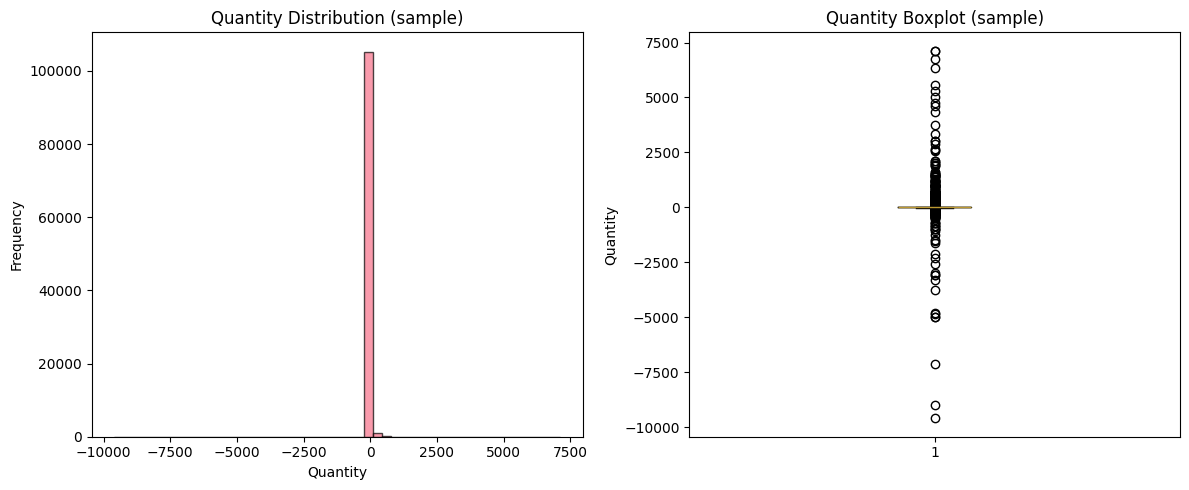

=== Quantity Quartiles (Q1, Median, Q3, P95) ===
[1.0, 3.0, 12.0, 36.0]
Return lines: 22,950 (2.15%)


In [ ]:
# 3) Quantity distribution (sample to pandas for histogram)
quant_sample = df.select("Quantity").sample(fraction=0.1, seed=42).toPandas()

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].hist(quant_sample["Quantity"], bins=50, edgecolor='black', alpha=0.7)
ax[0].set_title("Quantity Distribution (sample)")
ax[0].set_xlabel("Quantity")
ax[0].set_ylabel("Frequency")

# Boxplot
ax[1].boxplot(quant_sample["Quantity"], vert=True)
ax[1].set_title("Quantity Boxplot (sample)")
ax[1].set_ylabel("Quantity")
plt.tight_layout()
plt.show()

# Quartiles using Spark (no collect of all data)
quartiles = df.approxQuantile("Quantity", [0.25,0.5,0.75,0.95], 0.01)
print("=== Quantity Quartiles (Q1, Median, Q3, P95) ===")
print(quartiles)

# Returns share
returns_count = df.filter(F.col("Quantity") < 0).count()
returns_pct = returns_count / df.count() * 100
print(f"Return lines: {returns_count:,} ({returns_pct:.2f}%)")


=== Top 10 Products by Quantity ===
+---------+-------------+------------------+
|StockCode|TotalQuantity|      TotalRevenue|
+---------+-------------+------------------+
|    84077|       108545| 24898.22000000003|
|   85123A|        96066|253720.01999999926|
|   85099B|        95739|181278.51000000164|
|    21212|        95450|  52447.5400000005|
|    84879|        80705| 131413.8499999994|
|    22197|        79363| 80300.07000000014|
|    17003|        70700|14743.410000000003|
|    21977|        56575|28373.680000000095|
|    84991|        54366| 27216.27000000011|
|    22492|        45384|28863.539999999855|
+---------+-------------+------------------+


=== Bottom 5 Products by Quantity (>0) ===
+---------+-------------+------------+
|StockCode|TotalQuantity|TotalRevenue|
+---------+-------------+------------+
|   46138D|            1|        1.95|
|    21860|            1|        5.17|
|    21148|            1|         0.0|
|   85024A|            1|        1.65|
|   84877C|     

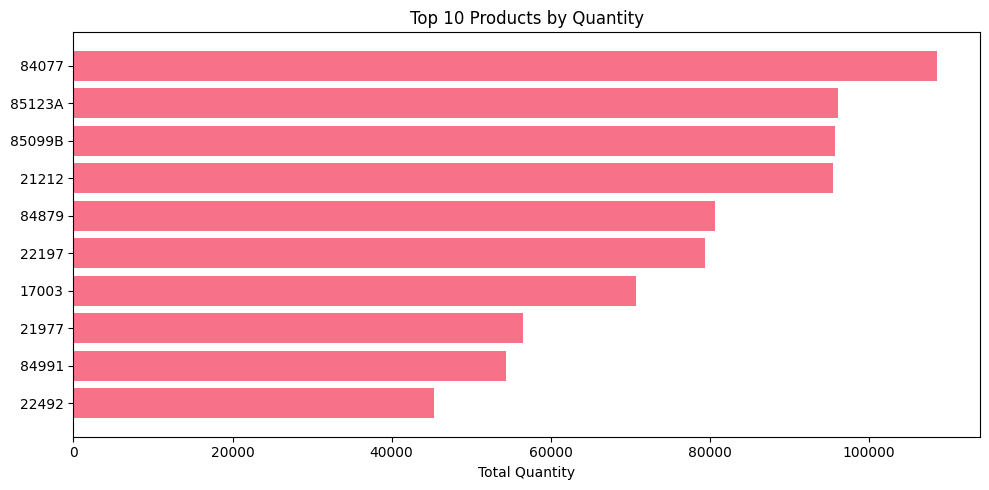

In [ ]:
# 4) Top and bottom products
product_sales = df.groupBy("StockCode").agg(
    F.sum("Quantity").alias("TotalQuantity"),
    F.sum(F.col("Quantity") * F.col("Price")).alias("TotalRevenue")
)

# Top 10 by quantity
top_products = product_sales.orderBy(F.desc("TotalQuantity")).limit(10)
print("=== Top 10 Products by Quantity ===")
top_products.show()

# Bottom 5 (exclude negative or zero)
bottom_products = product_sales.filter(F.col("TotalQuantity") > 0) \
                              .orderBy(F.asc("TotalQuantity")).limit(5)
print("\n=== Bottom 5 Products by Quantity (>0) ===")
bottom_products.show()

# Plot top 10 bar chart
pdf_top = top_products.toPandas()
plt.figure(figsize=(10,5))
plt.barh(pdf_top["StockCode"].astype(str), pdf_top["TotalQuantity"])
plt.gca().invert_yaxis()
plt.xlabel("Total Quantity")
plt.title("Top 10 Products by Quantity")
plt.tight_layout()
plt.show()


# 3. Data Preparation

## 3.0 Setup: Spark Initialization and Data Loading

Initialize Spark session and load the Online Retail II dataset for data preparation steps.


In [1]:
# 3.0 Setup: Spark Initialization and Data Loading
import os
import time
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.storagelevel import StorageLevel

print("🔄 Initializing Spark session for data preparation...")

# 1) Force stop any existing Spark session
try:
    spark.stop()
    print("✅ Stopped existing Spark session")
except:
    print("ℹ️ No existing Spark session to stop")

time.sleep(2)  # Wait for cleanup

# 2) Create stable directories for Windows
stable_tmp = "D:/spark-tmp"
stable_wh = "D:/spark-warehouse"
os.makedirs(stable_tmp, exist_ok=True)
os.makedirs(stable_wh, exist_ok=True)

# 3) Set environment variables
os.environ["PYSPARK_PYTHON"] = "python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python"
os.environ["PYSPARK_TEMP_DIR"] = stable_tmp
os.environ["TMP"] = stable_tmp
os.environ["TEMP"] = stable_tmp

# 4) Initialize Spark session with stable configuration
spark = SparkSession.builder \
    .appName("OnlineRetailAnalysis") \
    .config("spark.local.dir", stable_tmp) \
    .config("spark.sql.warehouse.dir", stable_wh) \
    .config("spark.python.worker.timeout", "1200") \
    .config("spark.python.worker.reuse", "false") \
    .config("spark.network.timeout", "800s") \
    .config("spark.rpc.askTimeout", "800s") \
    .config("spark.rpc.lookupTimeout", "800s") \
    .config("spark.sql.broadcastTimeout", "800s") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "false") \
    .config("spark.sql.autoBroadcastJoinThreshold", "-1") \
    .config("spark.driver.memory", "2g") \
    .config("spark.executor.memory", "2g") \
    .master("local[2]") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")
print("✅ Spark session initialized successfully!")

# 5) Load data from GitHub
print("📥 Loading Online Retail II dataset from GitHub...")

github_url = "https://raw.githubusercontent.com/Hachi630/BDAS/main/online_retail_II.xlsx"
excel_data = pd.read_excel(github_url, sheet_name=None)

# Get both sheets
sheet_2009_2010 = excel_data['Year 2009-2010']
sheet_2010_2011 = excel_data['Year 2010-2011']

print(f"2009-2010 data shape: {sheet_2009_2010.shape}")
print(f"2010-2011 data shape: {sheet_2010_2011.shape}")

# Combine datasets
pandas_df = pd.concat([sheet_2009_2010, sheet_2010_2011], ignore_index=True)
print(f"Combined data shape: {pandas_df.shape}")

# Convert to Spark DataFrame
df = spark.createDataFrame(pandas_df)

# Clean up pandas objects to free memory
del pandas_df, sheet_2009_2010, sheet_2010_2011, excel_data

# 6) Test Spark connection and cache DataFrame for stability
try:
    total_records = df.count()
    print(f"✅ Data loaded successfully: {total_records:,} records")
    
    # Cache DataFrame for better performance in subsequent operations
    df = df.repartition(2).persist(StorageLevel.MEMORY_ONLY)
    print("✅ DataFrame cached for better performance")
    
    # Show basic info
    print(f"Columns: {df.columns}")
    print("Sample data:")
    df.show(3, truncate=False)
    
except Exception as e:
    print(f"❌ Error testing Spark connection: {e}")
    print("💡 Try restarting Jupyter kernel and running this cell again")

print("🎯 Ready for data preparation steps!")


🔄 Initializing Spark session for data preparation...
ℹ️ No existing Spark session to stop
✅ Spark session initialized successfully!
📥 Loading Online Retail II dataset from GitHub...
2009-2010 data shape: (525461, 8)
2010-2011 data shape: (541910, 8)
Combined data shape: (1067371, 8)
❌ Error testing Spark connection: An error occurred while calling o76.count.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 0.0 failed 1 times, most recent failure: Lost task 0.0 in stage 0.0 (TID 0) (windows10.microdone.cn executor driver): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed). Consider setting 'spark.sql.execution.pyspark.udf.faulthandler.enabled' or'spark.python.worker.faulthandler.enabled' configuration to 'true' for the better Python traceback.
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$

## 3.1 Select the Data

Apply explicit selection criteria to create the modeling/analysis subset: country filter, remove returns/cancellations, drop irrelevant columns, and optional timeframe filter.


In [15]:
# 3.1 Select the Data (PySpark)
from pyspark.sql import functions as F
from pyspark.sql.functions import year

# Start from the current full DataFrame `df`
print("=== Initial shape ===")
init_rows = df.count()
init_cols = len(df.columns)
print(f"Rows, Columns: {init_rows:,}, {init_cols}")

# 1) Filter data to only include United Kingdom transactions
print("\n# Filter: Country == 'United Kingdom'")
df = df.filter(F.col("Country") == "United Kingdom")
print("After UK filter:", df.count())

# 2) Remove all returned/cancelled transactions
#    - Exclude invoices that start with 'C'
#    - Ensure no negative quantities (returns)
print("\n# Remove returns/cancellations")
if "Invoice" in df.columns:
    df = df.filter(~F.col("Invoice").startswith("C"))
elif "InvoiceNo" in df.columns:
    df = df.filter(~F.col("InvoiceNo").startswith("C"))
else:
    print("Warning: No Invoice/InvoiceNo column found; cannot filter cancellations")

# Remove negative quantities
before_neg = df.filter(F.col("Quantity") < 0).count()
df = df.filter(F.col("Quantity") >= 0)
after_neg = df.filter(F.col("Quantity") < 0).count()
print(f"Removed returns (Quantity<0): before={before_neg:,}, after={after_neg:,}")

# 3) Drop fields not needed for modeling
#    Adjust the drop list to your analysis scope
print("\n# Drop irrelevant columns")
drop_cols = []
for c in ["InvoiceNo", "Invoice", "Description"]:
    if c in df.columns:
        drop_cols.append(c)
if drop_cols:
    df = df.drop(*drop_cols)
print("Dropped columns:", drop_cols)

# 4) (Optional) Restrict data to 2011 only
#    Comment out if using full range
print("\n# Optional: Restrict to year 2011")
df = df.filter(year(F.col("InvoiceDate")) == 2011)
print("After year==2011 filter:", df.count())

# Final shape and quick preview
print("\n=== Final shape ===")
print("Rows, Columns:", df.count(), len(df.columns))
df.show(5, truncate=False)


=== Initial shape ===


Py4JJavaError: An error occurred while calling o454.count.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 1.0 failed 1 times, most recent failure: Lost task 0.0 in stage 1.0 (TID 2) (windows10.microdone.cn executor driver): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed). Consider setting 'spark.sql.execution.pyspark.udf.faulthandler.enabled' or'spark.python.worker.faulthandler.enabled' configuration to 'true' for the better Python traceback.
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:599)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:35)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:945)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:925)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:532)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:601)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:583)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:583)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.hashAgg_doAggregateWithoutKey_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:50)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:583)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:143)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:57)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:111)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:398)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:933)
	... 25 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$3(DAGScheduler.scala:2935)
	at scala.Option.getOrElse(Option.scala:201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2935)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2927)
	at scala.collection.immutable.List.foreach(List.scala:334)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2927)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1295)
	at scala.Option.foreach(Option.scala:437)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3207)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3141)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3130)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:50)
Caused by: org.apache.spark.SparkException: Python worker exited unexpectedly (crashed). Consider setting 'spark.sql.execution.pyspark.udf.faulthandler.enabled' or'spark.python.worker.faulthandler.enabled' configuration to 'true' for the better Python traceback.
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:599)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:35)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:945)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:925)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:532)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:601)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:583)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:583)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.hashAgg_doAggregateWithoutKey_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:50)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:583)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:143)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:57)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:111)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:398)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:933)
	... 25 more


## 3.2 Data Cleaning

Apply cleaning steps aligned with the analysis rationale: drop/impute missing IDs (if chosen), remove cancellations/returns to focus on actual sales, optionally remove extreme outliers, and perform light text tidying.


In [ ]:
# 3.2 Data Cleaning (PySpark)
from pyspark.sql import functions as F
from pyspark.sql.functions import trim

print("=== Data Cleaning Start ===")
start_rows = df.count()
print(f"Rows before cleaning: {start_rows:,}")

# 1) Remove transactions with missing Customer ID (optional)
#    Rationale: anonymous customers cannot be attributed in downstream analysis.
missing_cust_before = df.filter(F.col("Customer ID").isNull()).count() if "Customer ID" in df.columns else 0
print(f"Missing Customer ID before: {missing_cust_before:,}")
if "Customer ID" in df.columns:
	# Choice A (drop missing IDs) — typical if we will do any customer-level aggregations
	df = df.filter(F.col("Customer ID").isNotNull())
	# Choice B (alternative if keeping):
	# df = df.fillna({"Customer ID": -1})

# 2) Exclude cancelled orders and returned items
#    Rationale: focus on final sales that can contribute to waste.
if "Invoice" in df.columns:
	df = df.filter(~F.col("Invoice").startswith("C"))
elif "InvoiceNo" in df.columns:
	df = df.filter(~F.col("InvoiceNo").startswith("C"))

neg_before = df.filter(F.col("Quantity") < 0).count()
df = df.filter(F.col("Quantity") >= 0)
print(f"Negative quantities removed: {neg_before:,}")

# 3) (Optional) Remove extreme outliers by Quantity threshold
#    Rationale: avoid a handful of bulk orders dominating statistics (tune threshold per EDA).
#    Uncomment to apply, and print how many would be removed.
# outlier_threshold = 5000
# out_before = df.filter(F.col("Quantity") >= outlier_threshold).count()
# df = df.filter(F.col("Quantity") < outlier_threshold)
# print(f"Removed extreme outliers (Quantity >= {outlier_threshold}): {out_before:,}")

# 4) Light text tidying (strip Description whitespace)
if "Description" in df.columns:
	df = df.withColumn("Description", trim(F.col("Description")))

# 5) (Optional) Drop unneeded text columns to reduce width
# if "Description" in df.columns:
# 	df = df.drop("Description")

# Sanity checks after cleaning
missing_cust_after = df.filter(F.col("Customer ID").isNull()).count() if "Customer ID" in df.columns else 0
neg_after = df.filter(F.col("Quantity") < 0).count()

print("\n=== Cleaning Summary ===")
print(f"Missing Customer ID after: {missing_cust_after:,}")
print(f"Negative quantities after: {neg_after:,}")

print("\n=== Final shape ===")
print("Rows, Columns:", df.count(), len(df.columns))
df.show(5, truncate=False)
print("=== Data Cleaning Done ===")


=== Data Cleaning Start ===


Py4JJavaError: An error occurred while calling o86.count.
: org.apache.spark.SparkException: [INTERNAL_ERROR] The "count" action failed. You hit a bug in Spark or the Spark plugins you use. Please, report this bug to the corresponding communities or vendors, and provide the full stack trace. SQLSTATE: XX000
	at org.apache.spark.SparkException$.internalError(SparkException.scala:107)
	at org.apache.spark.sql.execution.QueryExecution$.toInternalError(QueryExecution.scala:643)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:656)
	at org.apache.spark.sql.classic.Dataset.$anonfun$withAction$1(Dataset.scala:2232)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$8(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.withSessionTagsApplied(SQLExecution.scala:272)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$7(SQLExecution.scala:125)
	at org.apache.spark.JobArtifactSet$.withActiveJobArtifactState(JobArtifactSet.scala:94)
	at org.apache.spark.sql.artifact.ArtifactManager.$anonfun$withResources$1(ArtifactManager.scala:112)
	at org.apache.spark.sql.artifact.ArtifactManager.withClassLoaderIfNeeded(ArtifactManager.scala:106)
	at org.apache.spark.sql.artifact.ArtifactManager.withResources(ArtifactManager.scala:111)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:295)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$1(SQLExecution.scala:124)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:804)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId0(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:237)
	at org.apache.spark.sql.classic.Dataset.withAction(Dataset.scala:2232)
	at org.apache.spark.sql.classic.Dataset.count(Dataset.scala:1499)
	at jdk.internal.reflect.GeneratedMethodAccessor78.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.lang.NullPointerException: Cannot invoke "org.apache.spark.sql.classic.SparkSession.sparkContext()" because the return value of "org.apache.spark.sql.execution.SparkPlan.session()" is null
	at org.apache.spark.sql.execution.SparkPlan.sparkContext(SparkPlan.scala:68)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.metrics$lzycompute(HashAggregateExec.scala:71)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.metrics(HashAggregateExec.scala:70)
	at org.apache.spark.sql.execution.SparkPlan.resetMetrics(SparkPlan.scala:147)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.resetMetrics(AdaptiveSparkPlanExec.scala:245)
	at org.apache.spark.sql.classic.Dataset.$anonfun$withAction$2(Dataset.scala:2233)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:654)
	... 27 more


## 3.3 Feature Engineering

Engineer transaction-level and product-level features to support downstream modeling and risk analysis.


In [ ]:
# 3.3 Feature Engineering (PySpark)
from pyspark.sql import functions as F

print("=== Feature Engineering Start ===")

# 1) TotalPrice of each line (quantity * unit price)
#    Note: column names might be Price or UnitPrice depending on sheet; handle both.
unit_col = "UnitPrice" if "UnitPrice" in df.columns else ("Price" if "Price" in df.columns else None)
if unit_col is None:
	raise ValueError("Neither 'UnitPrice' nor 'Price' column found.")

df = df.withColumn("TotalPrice", F.col("Quantity") * F.col(unit_col))

# 2) Ensure InvoiceDate is timestamp and derive date features
if dict(df.dtypes).get("InvoiceDate") != "timestamp":
	df = df.withColumn("InvoiceDate", F.to_timestamp("InvoiceDate"))

# InvoiceMonth as yyyy-MM string
df = df.withColumn("InvoiceMonth", F.date_format("InvoiceDate", "yyyy-MM"))  # e.g., 2011-12
# Numeric day of week (1=Sunday ... 7=Saturday)
df = df.withColumn("DayOfWeekNum", F.dayofweek("InvoiceDate"))
# Holiday season flag: November or December
df = df.withColumn("IsHolidaySeason", F.when(F.month("InvoiceDate").isin([11,12]), 1).otherwise(0))

print("Added: TotalPrice, InvoiceMonth, DayOfWeekNum, IsHolidaySeason")

# 3) Product-level aggregation (StockCode)
#    Aggregate total quantity, revenue, number of distinct invoices, first/last sale dates
invoice_col = "InvoiceNo" if "InvoiceNo" in df.columns else ("Invoice" if "Invoice" in df.columns else None)
if invoice_col is None:
	raise ValueError("Neither 'InvoiceNo' nor 'Invoice' column found for distinct invoice counts.")

product_stats = df.groupBy("StockCode").agg(
	F.sum("Quantity").alias("TotalQuantity"),
	F.count_distinct(F.col(invoice_col)).alias("NumInvoices"),
	F.sum("TotalPrice").alias("TotalRevenue"),
	F.min("InvoiceDate").alias("FirstSaleDate"),
	F.max("InvoiceDate").alias("LastSaleDate")
)

print("Product-level features computed: TotalQuantity, NumInvoices, TotalRevenue, First/LastSaleDate")

# 4) Recency: days since last sale (relative to max date in dataset)
max_date = df.agg(F.max("InvoiceDate").alias("maxDate")).collect()[0]["maxDate"]
product_stats = product_stats.withColumn("DaysSinceLastSale", F.datediff(F.lit(max_date), F.col("LastSaleDate")))
print("Added: DaysSinceLastSale (recency)")

# 5) WasteRisk label: low sales and stale recency → high risk
#    Simple rule; adjust thresholds based on your analysis
product_stats = product_stats.withColumn(
	"WasteRisk",
	F.when((F.col("TotalQuantity") < 5) & (F.col("DaysSinceLastSale") > 180), 1).otherwise(0)
)
print("Added: WasteRisk (1 = low sales & no sale in >180 days)")

# Preview results
print("\n=== Transaction-level columns added ===")
df.select("StockCode", unit_col, "Quantity", "TotalPrice", "InvoiceDate", "InvoiceMonth", "DayOfWeekNum", "IsHolidaySeason").show(5, truncate=False)

print("\n=== Product-level features (sample) ===")
product_stats.select("StockCode", "TotalQuantity", "NumInvoices", "TotalRevenue", "DaysSinceLastSale", "WasteRisk").orderBy(F.desc("TotalQuantity")).show(10, truncate=False)

print("=== Feature Engineering Done ===")


## 3.4 Integrate Various Data Sources

Read and combine multiple files (if any), join extra product information, and verify the integrated dataset.


In [ ]:
# 3.4 Integrate Various Data Sources (PySpark)
from pyspark.sql import functions as F

print("=== Data Source Integration ===")

# A) Read and combine multiple files (if provided separately)
#    Example for two yearly CSVs. Commented out by default — uncomment if used.
# df1 = spark.read.csv("online_retail_II_2009_2010.csv", header=True, inferSchema=True)
# df2 = spark.read.csv("online_retail_II_2010_2011.csv", header=True, inferSchema=True)
# df = df1.unionByName(df2)  # Combine two yearly datasets into one DataFrame
# print("After union:", df.count(), "rows |", len(df.columns), "columns")
# df.printSchema()

# B) Join additional product info (e.g., categories) keyed by StockCode
#    Example: join transaction-level df with a product catalog
# product_info = spark.read.csv("product_catalog.csv", header=True, inferSchema=True)
# df = df.join(product_info, on="StockCode", how="left")  # Add product category information by StockCode
# print("After left join with product_info:", df.count(), "rows |", len(df.columns), "columns")

# C) Alternatively, join at product level after aggregation
#    Example: product-level catalog joined to product_stats
# product_catalog = spark.read.csv("product_catalog.csv", header=True, inferSchema=True)
# product_stats = product_stats.join(product_catalog, on="StockCode", how="left")
# print("product_stats columns after join:", product_stats.columns)

# D) Verify combined dataset (min/max date, sample)
try:
	min_max = df.select(F.min("InvoiceDate").alias("minDate"), F.max("InvoiceDate").alias("maxDate")).collect()[0]
	print(f"Date range after integration: {min_max['minDate']} → {min_max['maxDate']}")
except Exception as e:
	print("Date verification skipped:", e)

print("Sample rows:")
df.limit(5).show(truncate=False)

print("=== Integration Section Complete ===")


## 3.5 Format the Data as Required

Convert data types, optionally encode categorical variables, assemble and scale features for modeling, and (optionally) split into train/test sets.


In [ ]:
# 3.5 Format the Data as Required (PySpark)
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler

print("=== Data Formatting Start ===")

# A) Convert data types (InvoiceDate to timestamp; Quantity to int; UnitPrice to double)
if dict(df.dtypes).get("InvoiceDate") != "timestamp":
	df = df.withColumn("InvoiceDate", F.to_timestamp("InvoiceDate"))

# If fields came as strings, cast them (guard with existence checks)
if dict(df.dtypes).get("Quantity") != "int":
	df = df.withColumn("Quantity", F.col("Quantity").cast("int"))

if "UnitPrice" in df.columns and dict(df.dtypes).get("UnitPrice") != "double":
	df = df.withColumn("UnitPrice", F.col("UnitPrice").cast("double"))
elif "Price" in df.columns and dict(df.dtypes).get("Price") != "double":
	df = df.withColumn("Price", F.col("Price").cast("double"))

print("Schema after type fixes:")
df.printSchema()

# B) (Optional) Encode categorical variables
# Example: Country (if retained) → index + one-hot (commented out by default)
# if "Country" in df.columns:
# 	indexer = StringIndexer(inputCol="Country", outputCol="CountryIndex", handleInvalid="keep")
# 	df_indexed = indexer.fit(df).transform(df)
# 	encoder = OneHotEncoder(inputCol="CountryIndex", outputCol="CountryVec")
# 	df = encoder.fit(df_indexed).transform(df_indexed)
# 	print("Added encoded Country features (CountryIndex, CountryVec)")

# C) Assemble and scale product-level features (for modeling)
#    Use product_stats created in Feature Engineering
assembler = VectorAssembler(
	inputCols=["TotalQuantity", "TotalRevenue", "DaysSinceLastSale"],
	outputCol="features"
)
product_vector_df = assembler.transform(product_stats)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
scalerModel = scaler.fit(product_vector_df)
product_scaled_df = scalerModel.transform(product_vector_df)

print("Sample scaled features:")
product_scaled_df.select("StockCode", "features", "scaledFeatures", "WasteRisk").show(5, truncate=False)

# D) (Optional) Split into train/test sets for modeling
train_df, test_df = product_scaled_df.randomSplit([0.8, 0.2], seed=42)
print(f"Train size: {train_df.count()} | Test size: {test_df.count()}")

print(f"Final product dataset count: {product_stats.count()} products")
product_stats.select("StockCode","TotalQuantity","WasteRisk").show(5, truncate=False)

print("=== Data Formatting Done ===")


# 4. Data transformation

## 4.1 Reduce the Data

Drop redundant features, optionally apply PCA to reduce dimensionality, and (optionally) sample for quick prototyping. Show the effect after reduction.


In [ ]:
# 4.1 Reduce the Data (PySpark)
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA as PCAml

print("=== Data Reduction Start ===")

# A) Feature selection: drop redundant/less-informative columns
#    Example: drop NumInvoices if highly correlated with TotalQuantity
if "NumInvoices" in product_stats.columns:
	product_stats = product_stats.drop("NumInvoices")
	print("Dropped feature: NumInvoices (assumed correlated with TotalQuantity)")

print("Remaining features in product_stats:", product_stats.columns)

# B) (Optional) PCA to reduce dimensionality
#    Assemble selected numeric features into a vector for PCA
pca_input_cols = ["TotalQuantity", "TotalRevenue", "DaysSinceLastSale"]
assembler = VectorAssembler(inputCols=pca_input_cols, outputCol="featVec")
prod_vec = assembler.transform(product_stats)

# Keep 2 principal components (adjust k as needed)
pca = PCAml(k=2, inputCol="featVec", outputCol="pcaFeatures")
pca_model = pca.fit(prod_vec)
prod_pca = pca_model.transform(prod_vec)

print("Explained variance by PCs:", pca_model.explainedVariance.toArray())
print("Example pcaFeatures:")
prod_pca.select("StockCode", "pcaFeatures", "WasteRisk").show(5, truncate=False)

# C) (Optional) Sampling for quick prototyping
# sample_df = product_stats.sample(withReplacement=False, fraction=0.5, seed=1)
# print(f"Sample size (50%): {sample_df.count()}")

print(f"Number of products considered: {product_stats.count()}")
print("=== Data Reduction Done ===")


## 4.2 Project the Data

Apply advanced projections/transformations (PCA, logs, interactions, optional clustering) to prepare data for modeling or visualization.


In [13]:
# 4.2 Project the Data (PySpark)
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA as PCAml
from pyspark.ml.clustering import KMeans

print("=== Data Projection Start ===")

# A) PCA on training set (if already split in 3.5)
try:
	assembler = VectorAssembler(inputCols=["TotalQuantity", "TotalRevenue", "DaysSinceLastSale"], outputCol="featVec")
	train_vec = assembler.transform(train_df)
	pca = PCAml(k=3, inputCol="featVec", outputCol="pcaFeatures")
	pca_model = pca.fit(train_vec)
	train_pca = pca_model.transform(train_vec)
	print("Explained variance by 3 PCs:", pca_model.explainedVariance.toArray())
	train_pca.select("pcaFeatures").show(5, truncate=False)
except Exception as e:
	print("PCA demo skipped (train_df not available?):", e)

# B) Log-transform skewed features (example)
product_stats = product_stats.withColumn("LogTotalSales", F.log1p(F.col("TotalQuantity")))  # log(1+x)
print("Added LogTotalSales (log1p of TotalQuantity)")

# C) Example interaction feature
product_stats = product_stats.withColumn("Revenue_x_Recency", F.col("TotalRevenue") * F.col("DaysSinceLastSale"))
print("Added Revenue_x_Recency interaction feature")

# D) (Optional) KMeans clustering on product features
try:
	vec_for_cluster = VectorAssembler(inputCols=["TotalQuantity", "TotalRevenue", "DaysSinceLastSale"], outputCol="featVec")
	prod_vec2 = vec_for_cluster.transform(product_stats)
	kmeans = KMeans(k=3, featuresCol="featVec", predictionCol="ClusterID", seed=42)
	kmodel = kmeans.fit(prod_vec2)
	product_stats = kmodel.transform(prod_vec2)
	print("Cluster sizes:")
	product_stats.groupBy("ClusterID").count().orderBy("ClusterID").show()
except Exception as e:
	print("KMeans demo skipped:", e)

print("Columns now available in product_stats:")
print(product_stats.columns)
print("=== Data Projection Done ===")


=== Data Projection Start ===
PCA demo skipped (train_df not available?): name 'train_df' is not defined


NameError: name 'product_stats' is not defined